# Fortran vs Python difusão de Calor 2D
### Ou porque não trazer faca para briga de bazuca

### Python Numba double for

In [49]:
import numpy as np
from numba import njit, prange

@njit(nogil=True, parallel=True)
def nstepDifusao(T, lmbda, N):    
    for i in prange(1, N-1):
        for j in prange(1, N-1):
            T[i, j] = lmbda*(T[i+1, j]-4*T[i, j]+T[i-1, j]+T[i, j+1]+T[i, j-1]) + T[i, j] 
            
@jit
def numbarodarSimulacao(N, niter, dt, save=10, lmbda=0.04175):
    """
    * N : numero de pontos discretização em x e y
    * duracao : em segundos da simulacao da difusao
    * lmbda : lambda predefido para garantir estabilidade numérica 
    igual à 0.04175 baseado no item 1
    * save : numero de 'snapshots' para salvar  
    
    O numero de iteracoes é calculado baseado na duracao
    """
    k = 0.835 #K alumínio = 1/alfa^2
    ds = 10./(N-1) # 10 cm / N-1 pontos discretização espaço 
    #dt = (ds**2*lmbda)/k # discretização tempo garantindo lambda igual à 0.04175
    lmbda = (k*dt)/ds 
    # "paineis" com temperatura da placa em tn e tn+1 (derivada primeira 1 painel necessario)
    tplaca = np.zeros((N, N)) # temperatura da placa em tn e tn+1 : 
    # condições de contorno iniciais no tempo 0 
    # extremidades da placa 
    tplaca[:,  0] = 100. # esquerda 
    tplaca[:, -1] = 50. # direita
    # topo e base da placa assumindo temperatura = 0
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) # diferenciador convolucional        
    nsave = int(niter/save) # step de iteracoes para salvar 'snapshot'
    snapshots = np.zeros((save+1, N, N)) # 'filme' das iteracoes
    isnap = 0 # indice para salvar 'snapshots' das iteracoes        
    
    for n in range(niter): # marcha
        # calcula tn+1 em funcao de f(tn) 
        nstepDifusao(tplaca, lmbda, N)

### Morelatto Convolve 1D

In [50]:
from scipy.ndimage.filters import convolve1d

def conv1drodarSimulacao(nx = 101, ny=101, nt=101, dt=0.1, dx=0.01, dy=0.01):
    T_l = 100 #°C - Temperatura do lado esquerdo da chapa
    T_r = 50 #°C - Temperatura do lado esquerdo da chapa
    T_u = 25 #°C - Temperatura de cima da chapa
    T_d = 75 #°C - Temperatura de baixo da chapa


    K = 9.7 * 1e-5 # Difusividade térmica do aluminio (m²/s)
                   # fonte: www.electronics-cooling.com/2007/08/thermal-diffusivity/

    lbd_x = K * dt/dx**2 # Constante lambda x
    lbd_y = K * dt/dy**2 # Constante lambda y

    assert lbd_x < 0.5 # Condição de estabilidade eixo x
    assert lbd_y < 0.5 # Condição de estabilidade eixo y

    # Inicializando a temperatura da chapa
    T = np.zeros((nx, ny))
    T[:,0] = T_l
    T[:,-1] = T_r
    T[0,:] = T_u
    T[-1,:] = T_d

    kernel = np.array([1,-2,1]) # Convolution kernel

    # Loop implementando as diferenças finitas
    for n in np.arange(nt):
        T[1:-1,1:-1] += lbd_x * convolve1d(T,kernel, axis=0, mode='constant')[1:-1,1:-1] +\
                        lbd_y * convolve1d(T,kernel, axis=1, mode='constant')[1:-1,1:-1]

### Cython double for

In [51]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [53]:
%%cython
cimport cython
cimport numpy as np
import numpy as np
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef cstepDifusao(double [:,::1] T, double lmbda, int N):    
    cdef int i, j
    for i in prange(1, N-1, nogil=True):
        for j in prange(1, N-1, nogil=True):
            T[i, j] = lmbda*(T[i+1, j]-4*T[i, j]+T[i-1, j]+T[i, j+1]+T[i, j-1]) + T[i, j] 

        
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cythonrodarSimulacao(int N, int niter, double dt):
    """
    * N : numero de pontos discretização em x e y
    * duracao : em segundos da simulacao da difusao
    * lmbda : lambda predefido para garantir estabilidade numérica 
    igual à 0.04175 baseado no item 1
    * save : numero de 'snapshots' para salvar  
    
    O numero de iteracoes é calculado baseado na duracao
    """
    cdef double lmbda=0.04175
    #cdef double k = 0.835 #K alumínio = 1/alfa^2
    #cdef double ds = 10./(N-1) # 10 cm / N-1 pontos discretização espaço 
    # "paineis" com temperatura da placa em tn e tn+1 (derivada primeira 1 painel necessario)
    T = np.empty((N, N), dtype=np.float64)    
    # condições de contorno iniciais no tempo 0 
    # extremidades da placa 
    T[:,  0] = 100. # esquerda 
    T[:, -1] = 50. # direita
    # topo e base da placa assumindo temperatura = 0

    for n in range(niter): # marcha
        # calcula tn+1 em funcao de f(tn) 
        cstepDifusao(T, lmbda, N)


Error compiling Cython file:
------------------------------------------------------------
...
@cython.wraparound(False)
@cython.nonecheck(False)
cdef cstepDifusao(double [:,::1] T, double lmbda, int N):    
    cdef int i, j
    for i in prange(1, N-1, nogil=True):
        for j in prange(1, N-1, nogil=True):
                      ^
------------------------------------------------------------

/home/andre/.cache/ipython/cython/_cython_magic_b9a8f28eca8bdf15601c743f48b6c43d.pyx:12:23: Trying to release the GIL while it was previously released.


TypeError: object of type 'NoneType' has no len()

## CUDA Pytorch

In [54]:
import torch as th
import torch.nn.functional as F
import numpy as np

#th.set_num_threads(8)

def torchrodarSimulacao(N, niter, dt, save=10, lmbda=0.04175):
    """
    * N : numero de pontos discretização em x e y
    * duracao : em segundos da simulacao da difusao
    * lmbda : lambda predefido para garantir estabilidade numérica 
    igual à 0.04175 baseado no item 1
    * save : numero de 'snapshots' para salvar  

    O numero de iteracoes é calculado baseado na duracao
    """
    k = 0.835 #K alumínio = 1/alfa^2
    ds = 10./(N-1) # 10 cm / N-1 pontos discretização espaço 
    tplaca = np.zeros((N, N)) # temperatura da placa em tn e tn+1 : 
    # condições de contorno iniciais no tempo 0 
    # extremidades da placa 
    tplaca[:,  0] = 100. # esquerda 
    tplaca[:, -1] = 50. # direita
    # topo e base da placa assumindo temperatura = 0
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) # diferenciador convolucional        
    nsave = int(niter/save) # step de iteracoes para salvar 'snapshot'
    snapshots = np.zeros((save+1, N, N)) # 'filme' das iteracoes
    isnap = 0 # indice para salvar 'snapshots' das iteracoes        

    # pytorch wrapping
    kernel = th.tensor(kernel, dtype=th.float32)
    kernel = kernel.unsqueeze(0).unsqueeze(0)     # pytorch format for conv2d
    tplaca = th.tensor(tplaca, dtype=th.float32)
    tplaca = tplaca.unsqueeze(0).unsqueeze(0)  
    snapshots = th.tensor(snapshots, dtype=th.float32)

    # send to cuda 
    #     kernel = kernel.to("cuda")
    #     tplace = tplace.to("cuda")
    #     snapshots = snapshots.to("cuda")

    for n in range(niter): # marcha
        # calcula tn+1 em funcao de f(tn) 
        tplaca[0, 0, 1:-1, 1:-1] = lmbda*F.conv2d(tplaca, kernel) + tplaca[0, 0, 1:-1, 1:-1]

        if n%nsave==0:
            snapshots[isnap] = tplaca.squeeze(0).squeeze(0)
            isnap += 1 # p/ próximo 'frame' do 'filme'

    # imprime um resumo de alguns parâmetros
    #print('Dt: {:.3g} numero de Iteracoes: {:5d} '.format(dt, niter))

    # salva o último
    snapshots[-1] = tplaca.squeeze(0).squeeze(0)
    # retorna o 'filme' de snapshots, e o intervalo em x    
    return snapshots, ds

## Comparação para diferentes valores de NxN (grid da placa)


**Numero de iterações 10 dt = 0.1 **

In [55]:
# !x,y,t,nsnap
# !dx,dy,dt
# !alfa,Tesq,Tdir,Tsup,Tinf
#r"""1000 1000 200 9
#2 2 0.1
#0.835 100.0 200.0 100.0 200.0
#"""

# 3 Algoritmos 

## 1. Fortran  
## 2. Python Numba Double For 
## 3. Python Tweek Conv. 1D  
## 4. Python Cython Double For
## 5. Pytorch Cuda

In [56]:
from subprocess import call
import time

## fortran loop
def fortran(N):
    N=N*2 # devido ao dx=2    
    command = "{:} {:} 10 9\n 2 2 0.1\n0.835 100.0 200.0 100.0 200.0".format(N,N)
    with open('in.txt','w') as f:
        f.write(command)
    call('./calor2d.bin', shell=True)
    
## Python numba
def pythonnumba(N):
    numbarodarSimulacao(N, 100, 0.1)

## Python convolução 1D a little tweek
def pythonconv1d(N):
    conv1drodarSimulacao(N, N, 100, 0.1)

## Torch CUDA
def pythontorch(N):
    torchrodarSimulacao(N, 100, 0.1)    

## Cython for loop    
def pythoncython(N):
    cythonrodarSimulacao(N, 100, 0.1)  
    
# chama funcao com parâmetro N
def callfunc(func, N):    
    start = time.time()
    func(N)
    end = time.time()    
    return end-start

In [57]:
cd /home/andre/PycharmProjects/master/calor2D/

/home/andre/PycharmProjects/master/calor2D


### Plota comparação

In [58]:
nxn = list(range(300, 3000, 500))

In [59]:
py1d = []
fort = []
pytorch = []
cython = []
pynumba = []
for i, N in enumerate(nxn):
    
    py1d.append(callfunc(pythonconv1d, N))
    fort.append(callfunc(fortran, N))
    pytorch.append(callfunc(pythontorch, N))
    cython.append(callfunc(pythoncython, N))
    pynumba.append(callfunc(pythonnumba, N))
    print(i)

0
1
2
3
4
5


In [60]:
%matplotlib inline

In [61]:
from matplotlib import pyplot as plt

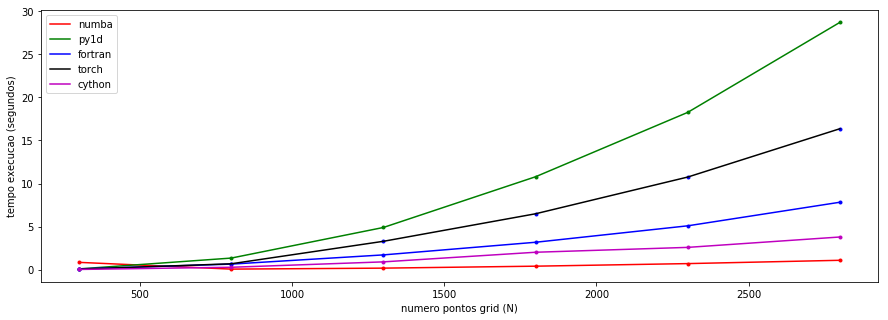

In [62]:
plt.figure(figsize=(15,5))
plt.plot(nxn, pynumba, '.r')
plt.plot(nxn, pynumba, '-r', label='numba')
plt.plot(nxn, py1d, '.g')
plt.plot(nxn, py1d, '-g', label='py1d')
plt.plot(nxn, fort, '.b')
plt.plot(nxn, fort, '-b', label='fortran')
plt.plot(nxn, pytorch, '.b')
plt.plot(nxn, pytorch, '-k', label='torch')
plt.plot(nxn, cython, '.m')
plt.plot(nxn, cython, '-m', label='cython')
plt.ylabel('tempo execucao (segundos)')
plt.xlabel('numero pontos grid (N)')
plt.legend()
#plt.ylim(0, )